The following is an intermediate use case. The first step is to examine the database of concern, contained within the folder example_db.

In [7]:
import pandas as pd
import os

db_path = 'example_db'
files = os.listdir(db_path)

#print out which file we are selecting for this example
print('Experimental Run File: {}'.format(files[0]))

example_csv = pd.read_csv(os.path.join(db_path,files[0],'raw.csv'),index_col = 0,
                          parse_dates = True,infer_datetime_format = True)

columns_of_interest = ['Tvent [K]', 'Tl8 [C]', 'T6 [C]', 'T4 [C]', 'T2 [C]',
       'Pbypass [PSI]', 'dPbypass [PA]', 'dPtest [PSI]', 'Pvent [PSI]',
       'Tbypass [K]', 'Treturn [K]', 'Tout [C]', 'Tin [C]', 'Preturn [PSI]',
       'dPreturn [PA]', 'dPvent [PA]', 'Ptest [PSI]']

#take the quantities we are interested in
df = example_csv[columns_of_interest]


Experimental Run File: 06_26_2017 15_43_380000


The next block makes use of the sensor package to manage the sensors used to collect the data

In [8]:
import sys
sys.path.append('..')
from sensor.sensor import SensorArray

#read in the sensor array information from the file and print out the information we are concerned with
#namely the measure units and the uncertainty
sensors = SensorArray.from_file('example_db\sensor.yaml')
table = sensors.to_table(include = ['measure_units','uncertainty'],columns = 'attribute',tablefmt = 'fancy')
print(table)
#pass a copy of the sensor because when operators are done on later blocks, coming back to this block
#may cause issue because the values of df change
udf = sensors.uDataFrame(df.copy())

          uncertainty                                     measure_units
--------  ----------------------------------------------  ---------------
Pbypass   0 [PSI]                                         ['PSI']
Preturn   12 [PSI]                                        ['PSI']
Ptest     5 [PSI]                                         ['PSI']
Pvent     5 [PSI]                                         ['PSI']
T2        ['1.1 [C]', '0.4 [%]', 'max']                   ['C']
T4        ['1.1 [C]', '0.4 [%]', 'max']                   ['C']
T6        ['1.1 [C]', '0.4 [%]', 'max']                   ['C']
Tbypass   ['1.1 [K]', 'y = 0.004*(x-273.15) [K]', 'max']  ['K']
Tin       y = 0.15 + 0.002*x [C]                          ['C']
Tl8       ['1.1 [C]', '0.4 [%]', 'max']                   ['C']
Tout      y = 0.15 + 0.002*x [C]                          ['C']
Treturn   ['1.1 [K]', 'y = 0.004*(x-273.15) [K]', 'max']  ['K']
Tvent     ['1.1 [K]', 'y = 0.004*(x-273.15) [K]', 'max']  ['K']
dPbypass  0 [P

Let as now consider the calculations we want to do with this data. For this particular experiement, significant post-processing of the data is required to find the results that we want. They are detailed in the next few blocks.

In [9]:
pressure_atmosphere = 14.7    #pressure of the atmosphere in [PSI]

def correct_venturi_pressure_differential(dP:pd.Series,
                                          P:pd.Series) -> pd.Series:
    
    """
    correct the differential pressure reading on the venturi using 
    the differential measurement and the static pressure
    """
    
    denominator = 0.019969+ 0.131*P*1e-6-0.003967
    return 23.867*((dP+5.9175)/1491.69 - 0.0003967)/denominator
    
def correct_main_pressure_differential(dP:pd.Series,
                                       P:pd.Series) -> pd.Series:
    
    """
    correct the differential pressure reading on the main line
    using the differential measurement and the static pressure
    """
    
    denominator = 0.02 + 0.285*P*1e-6 - 0.004
    return 5972.16*((dP+1493)/373250 - 0.004)*1/denominator

    
#correct the pressure readings. I've use the .loc here because this actually accesss the data
#from the data frame whereas df[name] accesses a copy of the data and can cause problems
df.loc[:,'dPvent [PA]'] = correct_venturi_pressure_differential(df.loc[:,'dPvent [PA]'],
                                                                df.loc[:,'Pvent [PSI]'])

udf.loc[:,'dPvent [PA]']  = correct_venturi_pressure_differential(udf.loc[:,'dPvent [PA]'],
                                                        udf.loc[:,'Pvent [PSI]'])


df.loc[:,'dPreturn [PA]'] = correct_main_pressure_differential(df.loc[:,'dPreturn [PA]'],
                                                                df.loc[:,'Preturn [PSI]'])
    

udf.loc[:,'dPreturn [PA]'] = correct_main_pressure_differential(udf.loc[:,'dPreturn [PA]'],
                                                                udf.loc[:,'Preturn [PSI]'])

#we have calculated the pressure at the inlet "Pinlet", the pressure at the outlet "Pressure outlet"
#and updated the venturi field to be the absolute pressure
df.loc[:,'Pinlet [PSI]'] = df.loc[:,'Ptest [PSI]'] + df.loc[:,'dPtest [PSI]'] + pressure_atmosphere
df.loc[:,'Poutlet [PSI]'] = df.loc[:,'Ptest [PSI]'] + pressure_atmosphere
df.loc[:,'Pvent [PSI]'] += pressure_atmosphere

udf.loc[:,'Pinlet [PSI]'] = udf.loc[:,'Ptest [PSI]'] + udf.loc[:,'dPtest [PSI]'] + pressure_atmosphere
udf.loc[:,'Poutlet [PSI]'] = udf.loc[:,'Ptest [PSI]'] + pressure_atmosphere
udf.loc[:,'Pvent [PSI]'] += pressure_atmosphere

#calculate the average temperature of the helium
df.loc[:,'Taverage [C]'] = (df.loc[:,'Tin [C]'] + df.loc[:,'Tout [C]'])/2
df.loc[:,'Paverage [PSI]'] = (df.loc[:,'Pinlet [PSI]'] + df.loc[:,'Poutlet [PSI]'])/2

udf.loc[:,'Taverage [C]'] = (udf.loc[:,'Tin [C]'] + udf.loc[:,'Tout [C]'])/2
udf.loc[:,'Paverage [PSI]'] = (udf.loc[:,'Pinlet [PSI]'] + udf.loc[:,'Poutlet [PSI]'])/2


C:\Users\mlanahan\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


The next block leverages the CoolProp package, an open source version of REFPROP10 maintained by Ian Bell. The main goal of the block is to compute the mass flow rate of the Helium, using a venturi meter relationship, and also calculate the Reynolds number of the Helium at the Jet

In [10]:
import CoolProp as cp
import json
import numpy as np
from uncertainties import ufloat

#there is a seperate data file that keeps track of some engineering
#data needed for the computation
with open('constants.json','r') as file:
    Constants = json.load(file)

C_d = Constants['Cd']
A1 = Constants['A1']
A2 = Constants['A2']
Aj = Constants['Aj']
Dj = Constants['Dj']
Ah = Constants['Ah']
Ac = Constants['Ac']

uDj = ufloat(Dj,Constants['eDj'])
uAc = ufloat(Ac,Constants['eAc'])
uAh = ufloat(Ah,Constants['eAh'])
uAj = ufloat(Aj,Constants['eAj'])

PSI_TO_PASCAL = 6894.76   #conversion from psi to pascal

#get the viscosity
mu = cp.CoolProp.PropsSI('V',
                        'T',df.loc[:,'Taverage [C]'].to_numpy() + 273.15,
                        'P',df.loc[:,'Paverage [PSI]'].to_numpy()*PSI_TO_PASCAL,
                        'He') 


#get the specific heat
Cp = cp.CoolProp.PropsSI('CPMASS',
                        'T',df.loc[:,'Taverage [C]'].to_numpy() + 273.15,
                        'P',df.loc[:,'Paverage [PSI]'].to_numpy()*PSI_TO_PASCAL,
                        'He') 


#get the density
rho_he = cp.CoolProp.PropsSI('D',
                             'T',df.loc[:,'Tvent [K]'].to_numpy(),
                             'P',df.loc[:,'Pvent [PSI]'].to_numpy()*PSI_TO_PASCAL,
                             'He') 

#calculate mass flow rate
df.loc[:,'m_dot [kg/s]'] = C_d*A1*np.sqrt((2*rho_he*df.loc[:,'dPvent [PA]'])/((A1/A2)**2 -1))

#calculate reynolds number
df.loc[:,'Re [-]'] = df.loc[:,'m_dot [kg/s]']*Dj/(Aj*mu)

#calculate the heat flux using a control volume on the test section
df.loc[:,'q [W/m^2]'] = df.loc[:,'m_dot [kg/s]']*Cp*(df.loc[:,'Tout [C]'] - df.loc[:,'Tin [C]'])/Ah

For the next block, we will now find the point at which the data is "most steady state" by the following. At the conclusion of this block we now have the data which is most steady state. The first plot in the below shows the selected window plotted over the rolling mean of the data, while the second plot shows the selected window plotted against the raw data. 

After we find this most steady state data, we will then estimate the uncertainty in this data and compare it to the uncertainties of the sensors.

Finally, the uncertainties in the variables $\dot{m}, \text{Re}$, and $q^{"}$ are calculated at this point because the function that supports this, uPropsSI (import shown below) is _considerably_ slower than the regular propsSI function, so we want to call it on the smallest amount of data possible.

Steady State Values: 
Tvent [K]         3.053843e+02
Tl8 [C]           4.494493e+02
T6 [C]            4.505171e+02
T4 [C]            4.541307e+02
T2 [C]            4.371413e+02
Pbypass [PSI]     1.306236e+03
dPbypass [PA]     4.237682e+03
dPtest [PSI]      1.625484e+01
Pvent [PSI]       1.476420e+03
Tbypass [K]       4.331121e+02
Treturn [K]       3.038290e+02
Tout [C]          4.111661e+02
Tin [C]           4.043939e+02
Preturn [PSI]     1.293475e+03
dPreturn [PA]     4.897721e+03
dPvent [PA]       3.132406e+03
Ptest [PSI]       1.408346e+03
Pinlet [PSI]      1.439301e+03
Poutlet [PSI]     1.423046e+03
Taverage [C]      4.077800e+02
Paverage [PSI]    1.431173e+03
m_dot [kg/s]      7.271589e-03
Re [-]            2.801792e+04
q [W/m^2]         1.126464e+06
dtype: float64

----------------------
Estimated uncertainties in the sensor data and calculated values:
Tvent [K]             0.045478
Tl8 [C]               0.083228
T6 [C]                0.080532
T4 [C]                0.350588
T2 [C

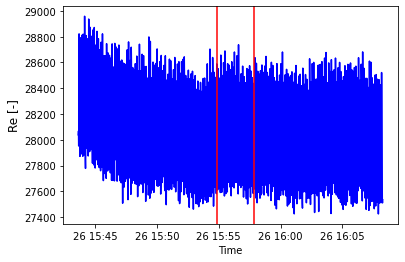

In [18]:
from matplotlib import pyplot as plt
from uncertainties_wrapped_propsSI import uPropsSI
from uncertainties.unumpy import sqrt as usqrt,nominal_values,std_devs,pow as upower
    
    
#get the number of samples for a 3 minute window
df.index = pd.to_datetime(df.index,format = '%m/%d/%Y %H:%M:%S:%f')
average_frequency = np.median((df.index[1:] - df.index[0:-1]).total_seconds().to_numpy())
sample_time = 180
num_samples = int(np.ceil(sample_time/average_frequency))

#get the window that minimizes coefficient of variation
rm = df.rolling(num_samples).mean()
coefficient_variation = df.rolling(num_samples).std()/rm

var_min_index = coefficient_variation['Re [-]'].argmin()
min_var_window = [var_min_index - num_samples,var_min_index]
index = int(var_min_index -num_samples/2)


#Plotting
#plot of the raw data with the selected minimal variance window
fig1,ax1 = plt.subplots()
ax1.plot(df['Re [-]'],color = 'blue')
ax1.axvline(rm.index[min_var_window[0]],color = 'red')
ax1.axvline(rm.index[min_var_window[1]],color = 'red')
ax1.set_ylabel('Re [-]',fontsize = 12)
ax1.set_xlabel('Time')

#get the windowed data
wdf = df.iloc[min_var_window[0]:min_var_window[1],:]
wudf = udf.iloc[min_var_window[0]:min_var_window[1],:]

#the data frame of steady-state values
ss_df = wdf.mean()

#print out the found steady state values
print('Steady State Values: ')
print(ss_df)

#compute the uncertainty of this data frame
estimated_uncertainty = wdf.std()
print('')
print('----------------------')
print('Estimated uncertainties in the sensor data and calculated values:')
print(estimated_uncertainty)

#compute the uncertainty derived values for m_dot, Re, and q
#get the viscosity
umu = uPropsSI('V',
              'T',np.array(wudf.loc[:,'Taverage [C]']) + 273.15,
              'P',np.array(wudf.loc[:,'Paverage [PSI]'])*PSI_TO_PASCAL,
              'He') 

#get the specific heat
uCp = uPropsSI('CPMASS',
              'T',np.array(wudf.loc[:,'Taverage [C]']) + 273.15,
              'P',np.array(wudf.loc[:,'Paverage [PSI]'])*PSI_TO_PASCAL,
              'He') 

#get the density
urho_he = uPropsSI('D',
                     'T',np.array(wudf.loc[:,'Tvent [K]']),
                     'P',np.array(wudf.loc[:,'Pvent [PSI]'])*PSI_TO_PASCAL,
                     'He') 


#calculate mass flow rate
wudf.loc[:,'m_dot [kg/s]'] = C_d*A1*usqrt((2*urho_he*wudf.loc[:,'dPvent [PA]'])/((A1/A2)**2 -1))

#calculate reynolds number
wudf.loc[:,'Re [-]'] = wudf.loc[:,'m_dot [kg/s]']*uDj/(uAj*umu)

#calculate the heat flux using a control volume on the test section
wudf.loc[:,'q [W/m^2]'] = wudf.loc[:,'m_dot [kg/s]']*uCp*(wudf.loc[:,'Tout [C]'] - wudf.loc[:,'Tin [C]'])/uAh

print('')
print('----------------------')
print('Mean Uncertainty Values')
ss_udf = pd.Series(np.mean(np.array(wudf),axis = 0),index =ss_df.index)
print(ss_udf)


For the next block, we have to solve a non-linear implicit function, specifically 

$$
|| T_r - \frac{q^{"}\delta_{tc}}{k_s} - T_{cr} || \quad \text{subject to} \\ 
k_s = k_{WL10}(T_m) \\ 
T_m = \frac{T_r + T_{cr}}{2}
$$

where $T_r,\delta_{tc}$ are data, specifically the recorded thermocouple temperatures and the distances of the thermocouples to the cooled surface. $T_{cr}$ is the variable we are attempting to solve for.

In [17]:
from scipy.optimize import minimize
from uncertainties.unumpy import umatrix

#lambda function for thermal conductivity: very similar to the concept of the 
#"anonymous function" in MatLab
thermal_conductivity = lambda x: 3.37238e-5*x**2 - 1.14272e-1*x + 206.822
uthermal_conductivity =lambda x:  3.37238e-5*np.power(x,2) - 1.14272e-1*x + 206.822

cs_temp_weights = np.array([0.5227,0.3181,0.1423,0.0169]) 
def cooled_surface_temp(T:np.ndarray) -> float:
    
    """
    calculates "T_c_bar" the area weighted average surface temperatures
    """
    
    return T.dot(cs_temp_weights)

def cooled_surface_temp_actual(T_r:np.ndarray,
                               q: float,
                               delta_tc:np.ndarray,
                               k_s:float) -> np.ndarray:
    
    """
    calculates the cooled surface actual temperature "T_{cr}" based upon:
    T_r : the thermo couple readings of the temperature
    q: the calculated heat flux
    delta_c: the distance to the thermo couple
    k_s: the thermal conductivity of the solid
    """
    
    return T_r - q*delta_tc/k_s


def temperature_diff_wrapped(q: float,
                             delta_tc: np.ndarray,
                             T_r:np.ndarray,
                             order = 1) -> callable:
    """
    the wrapping of the function to minimize. 
    q: control volume heat flux
    delta_tc: the distance of the thermocouples from the probe locations
    T_r: The measured temperature of the thermocouples
    """
    
    def objective_function(T_cr: np.ndarray) -> np.ndarray:

        """
        the function to minimize in order to get the non-linear
        relationship for the geometrically extrapolated cooled surface temperatures
        """
        
        Tm = (T_r + T_cr)/2.0
        ks = thermal_conductivity(Tm)
        T_cr_update = cooled_surface_temp_actual(T_r,q,delta_tc,ks)
        
        return np.linalg.norm(T_cr_update - T_cr,ord = 1)
    
    return objective_function

#calculate average coooled surface temperature and the conductivity of the WL10
delta_tc = np.array([0.0005730 ,0.0007468, 0.0008264, 0.000788]) 
u_delta_tc = umatrix(delta_tc,np.ones(delta_tc.shape)*0.1e-3)
Tr = np.array([ss_df['T2 [C]'],ss_df['T4 [C]'],ss_df['T6 [C]'],ss_df['Tl8 [C]']]) + 273.15
objective_function = temperature_diff_wrapped(ss_df['q [W/m^2]'],delta_tc,Tr)
Tcr = minimize(objective_function,Tr,method = 'Powell').x

#### APPROXIMATION HERE of uTr. 
#Unfortunately, we do NOT know the uncertainty of T_cr when getting the 
#uncertainty of ks, so we must approximate it to get the uncertainty of ks. 
#We approximate it with the uncertainty Tr
uTr = np.array([ss_udf['T2 [C]'],ss_udf['T4 [C]'],ss_udf['T6 [C]'],ss_udf['Tl8 [C]']]) + 273.15 
_uTcr = umatrix(Tcr,std_devs(uTr))
Tm = (uTr+_uTcr)/2.0
ks = uthermal_conductivity(Tm)
uTcr = cooled_surface_temp_actual(uTr,ss_udf['q [W/m^2]'],u_delta_tc,ks)

#print out some info on solving the implicit equation
print('=======================')
print('Residual on average temperature calculation: {}'.format(np.sum(objective_function(Tcr))))
print('=======================')
print('')

Tc = cooled_surface_temp(Tcr)
uTc = cooled_surface_temp(uTcr)
#get the fluid thermal conductivity
k_f = cp.CoolProp.PropsSI('L',
                'T',np.array(ss_df.loc['Taverage [C]'])+ 273.15,
                'P',np.array(ss_df.loc['Paverage [PSI]'])*PSI_TO_PASCAL,
                'He') 

uk_f = uPropsSI('L',
                'T',np.array(ss_udf.loc['Taverage [C]'])+ 273.15,
                'P',np.array(ss_udf.loc['Paverage [PSI]'])*PSI_TO_PASCAL,
                'He') 

rho_L = cp.CoolProp.PropsSI('D',
                'T',np.array(ss_df.loc['Taverage [C]'])+ 273.15,
                'P',np.array(ss_df.loc['Paverage [PSI]'])*PSI_TO_PASCAL,
                'He') 

urho_L = uPropsSI('D',
                'T',np.array(ss_udf.loc['Taverage [C]']) + 273.15,
                'P',np.array(ss_udf.loc['Paverage [PSI]'])*PSI_TO_PASCAL,
                'He') 

#calculate the average HTC
h_bar = ss_df['q [W/m^2]']/(Tc - ss_df['Tin [C]'] - 273.15)*Ah/Ac
Nu_bar = h_bar*Dj/k_f

#calculate the loss coefficient
v_bar = ss_df['m_dot [kg/s]']/(Aj*rho_L)
K_L = 2*PSI_TO_PASCAL*(ss_df['Pinlet [PSI]'] - ss_df['Poutlet [PSI]'])/(rho_L*v_bar**2)

print("Averaged Results with no uncertainty")
print('----------------------')
print('')
print('Average Nusselt Number: {}'.format(Nu_bar))
print('Averge Heat Transfer Coefficient: {}'.format(h_bar))
print('Heat Flux [W/m^2]:{}'.format(ss_df['q [W/m^2]']))
print('Average Reynolds Number: {}'.format(ss_df['Re [-]']))
print('Average Loss Coefficient: {}'.format(K_L))

#calculate the average HTC
u_hbar = np.array(ss_udf['q [W/m^2]'])/(uTc - np.array(ss_udf['Tin [C]']) - 273.15)*np.array(uAh/uAc)
uNu_bar = u_hbar*np.array(uDj)/uk_f

#calculate the loss coefficient
uv_bar = ss_udf['m_dot [kg/s]']/(uAj*urho_L)
uK_L = 2*PSI_TO_PASCAL*(ss_udf['Pinlet [PSI]'] - ss_udf['Poutlet [PSI]'])/(urho_L*uv_bar**2)

print('')
print("Averaged Results with uncertainty")
print('----------------------')
print('')
print('Average Nusselt Number: {}'.format(uNu_bar))
print('Averge Heat Transfer Coefficient: {}'.format(u_hbar))
print('Heat Flux [W/m^2]:{}'.format(ss_udf['q [W/m^2]']))
print('Average Reynolds Number: {}'.format(ss_udf['Re [-]']))
print('Average Loss Coefficient: {}'.format(uK_L))

Residual on average temperature calculation: 1.3642420526593924e-11

Averaged Results with no uncertainty
----------------------

Average Nusselt Number: 147.01463998971218
Averge Heat Transfer Coefficient: 39653.90788567147
Heat Flux [W/m^2]:1126463.550492028
Average Reynolds Number: 28017.923127800612
Average Loss Coefficient: 1.6935213285781112

Averaged Results with uncertainty
----------------------

Average Nusselt Number: [[147.01463998971644+/-7.862488991711691]]
Averge Heat Transfer Coefficient: [[39653.90788567263+/-929.0969759263222]]
Heat Flux [W/m^2]:(1.126+/-0.017)e+06
Average Reynolds Number: (2.80+/-0.14)e+04
Average Loss Coefficient: 1.69+/-0.04
